In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# load data
x_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_easy.npz')['data']
y_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_easy.npy')
x_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_medium.npz')['data']
y_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_medium.npy')
x_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_hard.npz')['data']
y_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_hard.npy')
x_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_real.npz')['data']
y_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_real.npy')

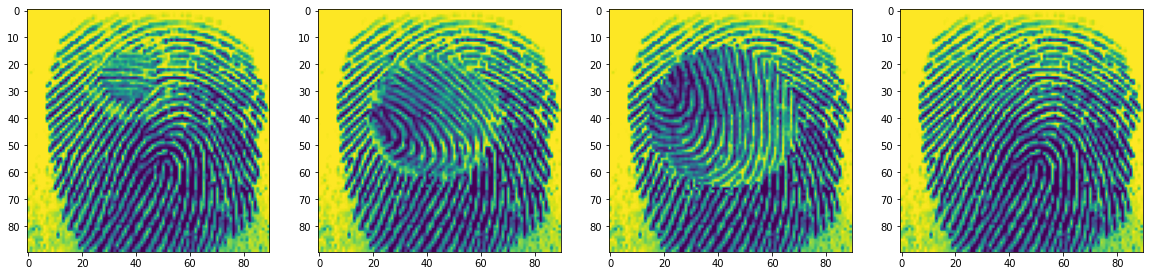

In [ ]:
# check data
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(x_easy[0].squeeze())
plt.subplot(1, 4, 2)
plt.imshow(x_medium[0].squeeze())
plt.subplot(1, 4, 3)
plt.imshow(x_hard[0].squeeze())
plt.subplot(1, 4, 4)
plt.imshow(x_real[0].squeeze())

In [ ]:
y_easy[0], y_medium[0], y_hard[0], y_real[0]

(array([100,   0,   0,   1], dtype=uint16),
 array([100,   0,   0,   1], dtype=uint16),
 array([100,   0,   0,   1], dtype=uint16),
 array([100,   0,   0,   1], dtype=uint16))

In [ ]:
# data preprocessing
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

X_train, X_test, y_train, y_test = train_test_split(x_data, label_data, test_size=0.1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

X_real, y_real = x_real, y_real

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(44343, 90, 90, 1) (44343, 4)
(2463, 90, 90, 1) (2463, 4)
(2464, 90, 90, 1) (2464, 4)


In [ ]:
# image preprocessing, distorting
import imgaug.augmenters as iaa

iaa_seq = iaa.Sequential([
                      iaa.GaussianBlur(sigma=(0,0.5)),
                      iaa.Affine(
                          scale={'x': (0.9, 1.1), 'y':(0.9, 1.1)},
                          translate_percent={'x':(-0.1, 0.1), 'y':(-0.1, 0.1)},
                          rotate=(-30, 30),
                          order=[0, 1],
                          cval=255
                      )
], random_order=True)

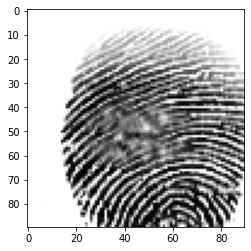

In [ ]:
target = X_train[1].squeeze()
plt.imshow(target, cmap=cm.gray)

(90, 90) (90, 90)


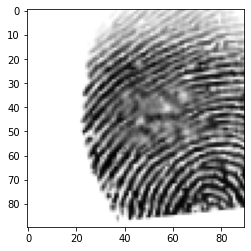

In [ ]:
target_ = iaa_seq(images=target)
plt.imshow(target_, cmap=cm.gray)
print(target.shape, target_.shape)

In [ ]:
from torchvision import transforms

custom_transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.GaussianBlur(kernel_size=[5,5], sigma=(0.3, 0.5)),
                                 transforms.RandomAffine(degrees=(-30,30), translate=(0.1, 0.1), scale=(0.9, 1.1), fill=1.)
])

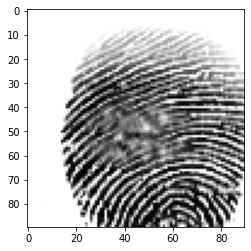

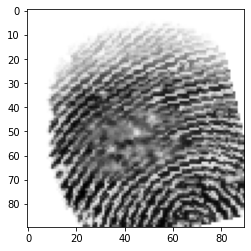

In [ ]:
plt.imshow(target.squeeze(), cmap=cm.gray)
plt.show()
target__ = custom_transform(target)
plt.imshow(target__.squeeze(), cmap=cm.gray)
plt.show()

In [ ]:
real_label2index = {}
for i, y in enumerate(y_real):
  key = y.astype(str)
  key = ''.join(key).zfill(6)
  real_label2index[key] = i

In [ ]:
import random
from torch.utils.data import Dataset
from torchvision import transforms

class FingerprintDataset(Dataset):
  def __init__(self, data, target, real_data, real_label2index, transform=transforms.ToTensor()):
    self.data = data
    self.target = target
    self.real_data = real_data
    self.real_label2index = real_label2index
    self.transform = transform
    self.totensor = transforms.ToTensor()
  def __len__(self):
    return len(self.target)
  
  def __getitem__(self, index):
    x1 = self.data[index]
    if self.transform is not None:
      x1 = self.transform(x1)
    else:
      x1 = self.totensor(x1)
    ####
    key = self.target[index].astype(str)
    key = ''.join(key).zfill(6)

    if random.random() > 0.5: # put matched image
      x2 = self.real_data[real_label2index[key]]
      y = 1.
    else:
      while True:
        unmatch_key, unmatch_index = random.choice(list(self.real_label2index.items()))
        if unmatch_key != key:
          break
      x2 = self.real_data[unmatch_index]
      y = 0.
    return [x1, self.totensor(x2)], y

In [ ]:
fingerprintData = FingerprintDataset(X_train, y_train, X_real, real_label2index, transform=custom_transform)

In [ ]:
(x1, x2), y = fingerprintData[20]

0.0


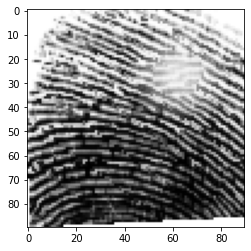

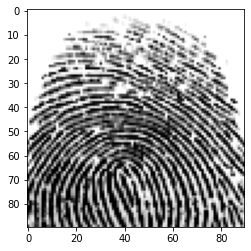

In [ ]:
print(y)
plt.imshow(x1.squeeze(), cmap=cm.gray)
plt.show()
plt.imshow(x2.squeeze(), cmap=cm.gray)
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_data = FingerprintDataset(X_train, y_train, X_real, real_label2index, transform=custom_transform)
val_data = FingerprintDataset(X_val, y_val, X_real, real_label2index, transform=custom_transform)
test_data = FingerprintDataset(X_test, y_test, X_real, real_label2index, transform=custom_transform)

train_dataloader = DataLoader(train_data, batch_size=64)
val_dataloader = DataLoader(val_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# Model

In [ ]:
import torch.nn as nn

In [ ]:
class FeatureLayers(nn.Module):
  def __init__(self):
    super(FeatureLayers, self).__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 32, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2),
    )

  def forward(self, inputs):
    x1, x2 = inputs
    ret1, ret2 = self.layers(x1), self.layers(x2)
    return ret1 - ret2

# featureModel = FeatureLayers().to(device)

In [ ]:
from torchvision import models

class FeatureLayers_resnet_based(nn.Module):

  def __init__(self):
    super(FeatureLayers_resnet_based, self).__init__()
    self.resnet = models.resnet18(num_classes=1)
    self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

  def _forward_impl(self, x):
    x = self.resnet.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)

    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)

    x = self.resnet.avgpool(x)
    return x

  def forward(self, inputs):
    x1, x2 = inputs
    ret1, ret2 = self._forward_impl(x1), self._forward_impl(x2)
    return ret1 - ret2

featureModel = FeatureLayers_resnet_based().to(device)

In [ ]:
class ProcessLayers(nn.Module):
  def __init__(self, in_channel=32, out_channel=32):
    super(ProcessLayers, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=1, padding='same'),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(out_channel, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, input):
    ret = self.layers(input)
    return ret

processModel = ProcessLayers(512, 128).to(device)

# Train

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(featureModel.parameters()) + list(processModel.parameters()), lr=0.001)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.9)

In [ ]:
# Train
epochs = 10 
batch_size = len(train_dataloader)
lr_steps = []
for epoch in range(epochs):
  lr_steps.append(optimizer.param_groups[0]['lr'])
  avg_train_cost = 0.
  featureModel.train()
  processModel.train()
  for X, y in train_dataloader:
    x1, x2 = X[0], X[1]
    x1, x2, y = x1.to(device), x2.to(device), y.view(-1, 1).to(device)
    out = featureModel([x1, x2])
    out = processModel(out)
    cost = loss_fn(out, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    avg_train_cost += cost.item() / batch_size
  print(f"Epoch : {epoch} - Avg cost : {avg_train_cost}")
  #### START OF VALIDATION
  sigmoid = nn.Sigmoid()
  val_cost = 0.
  val_correct = 0
  featureModel.eval()
  processModel.eval()
  for X, y in val_dataloader:
    x1, x2 = X[0], X[1]
    x1, x2, y = x1.to(device), x2.to(device), y.view(-1, 1).to(device)
    with torch.no_grad():
      out = featureModel([x1, x2])
      out = processModel(out)
      cost = loss_fn(out, y)
    val_cost += cost.item()
    y_pred = sigmoid(out.cpu())
    y_pred[y_pred >= 0.5] = 1.
    y_pred[y_pred < 0.5] = 0.
    val_correct += y_pred.eq(y.cpu()).int().sum()
  val_acc = val_correct / len(val_dataloader.dataset)
  print(f"Val_acc : {val_acc}")
  scheduler.step()


Epoch : 0 - Avg cost : 0.024458186866030875
Val_acc : 0.986601710319519
Epoch : 1 - Avg cost : 0.025211175663011676
Val_acc : 0.9805115461349487
Epoch : 2 - Avg cost : 0.021438654773534953
Val_acc : 0.9837596416473389
Epoch : 3 - Avg cost : 0.02003649140227844
Val_acc : 0.9788875579833984
Epoch : 4 - Avg cost : 0.019186414151386406
Val_acc : 0.9825416207313538
Epoch : 5 - Avg cost : 0.01877220451062663
Val_acc : 0.9890377521514893
Epoch : 6 - Avg cost : 0.0168394417253975
Val_acc : 0.9784815311431885
Epoch : 7 - Avg cost : 0.016402923278994695
Val_acc : 0.9890377521514893
Epoch : 8 - Avg cost : 0.016056752920240933
Val_acc : 0.9894437789916992
Epoch : 9 - Avg cost : 0.016617484661749685
Val_acc : 0.987007737159729


#Evaluation

TEST DATA : 2420 / 2464 ========


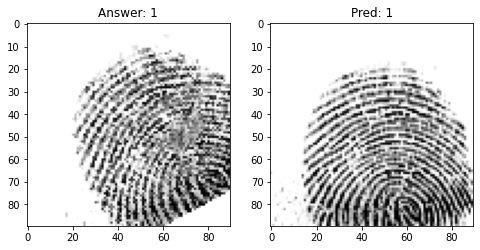

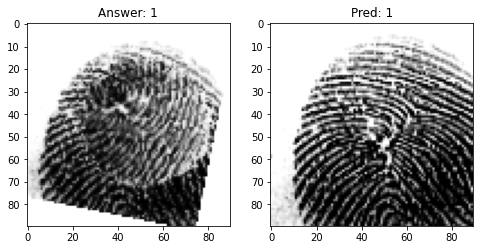

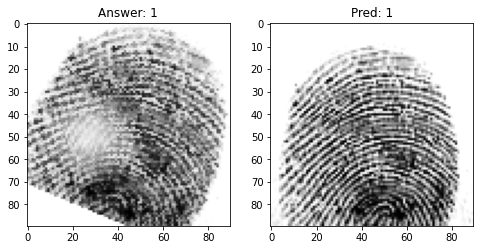

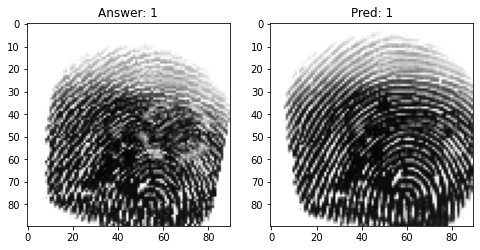

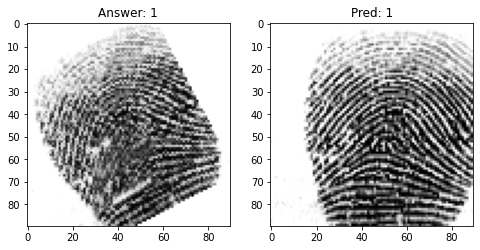

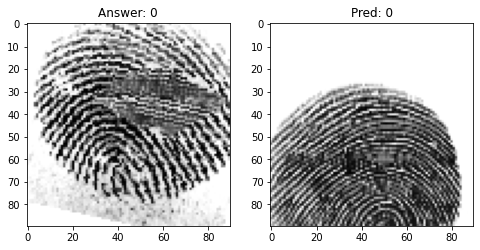

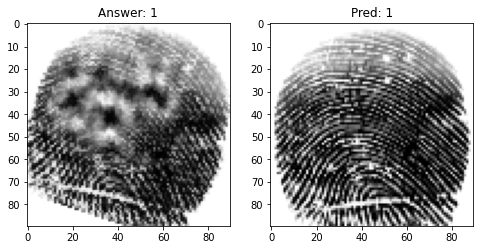

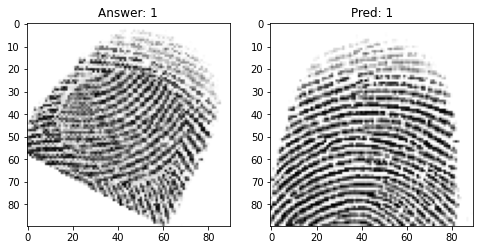

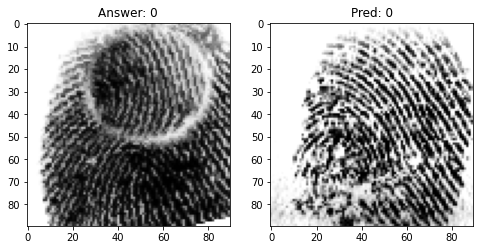

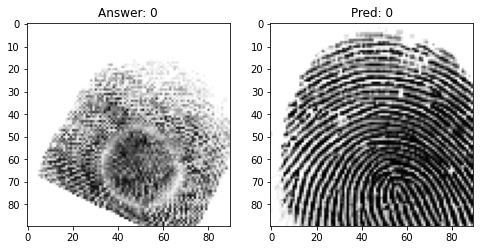

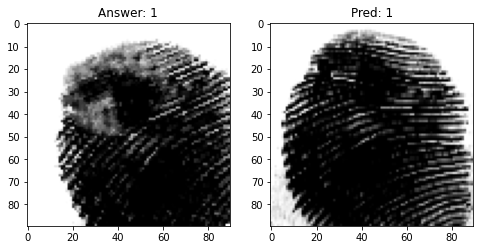

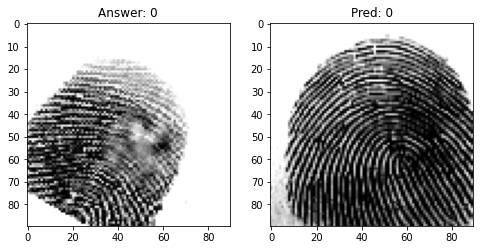

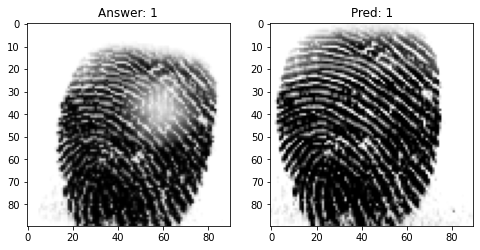

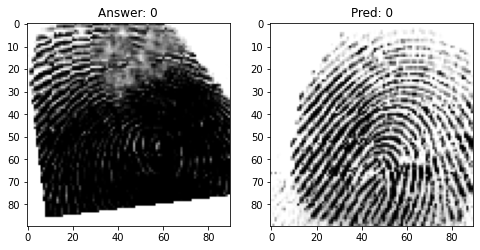

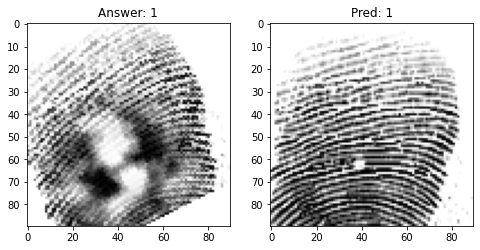

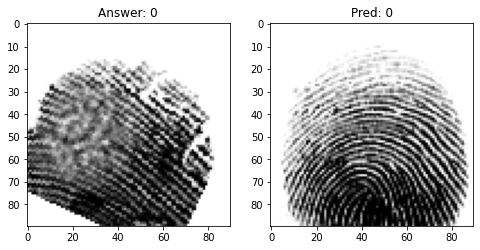

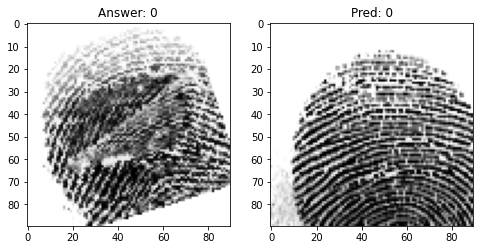

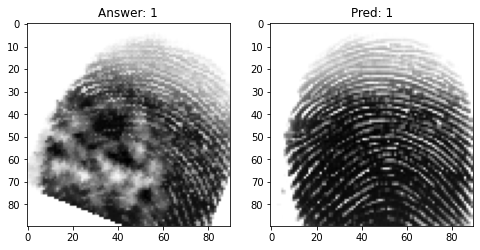

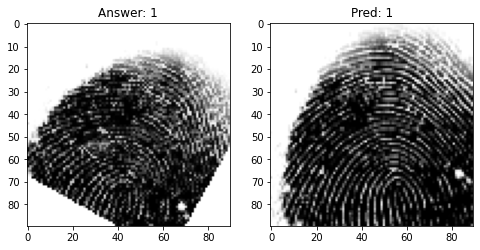

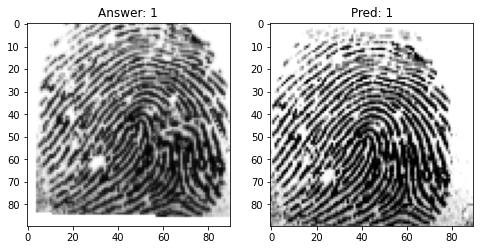

In [ ]:
sizes = 20
sigmoid = nn.Sigmoid()

test_correct = 0

featureModel.eval()
processModel.eval()
with torch.no_grad():
  for X, y in test_dataloader:
    x1, x2 = X
    x1, x2, y = x1.to(device), x2.to(device), y.view(-1, 1).to(device)
    out = featureModel([x1, x2])
    out = processModel(out)
    cost = loss_fn(out, y)
    y_pred = sigmoid(out.cpu())
    y_pred[y_pred >= 0.5] = 1.
    y_pred[y_pred < 0.5] = 0.
    test_correct += y_pred.eq(y.cpu()).int().sum()
  print(f"TEST DATA : {test_correct} / {len(test_dataloader.dataset)} ========")
  
  for i in range(sizes):
    random_index = random.randint(0, len(test_data))
    (x1, x2), y = test_data[random_index]
  
    x1_, x2_ = x1.unsqueeze_(0).to(device), x2.unsqueeze_(0).to(device)
    out = featureModel([x1_, x2_])
    pred = processModel(out)
    pred = sigmoid(pred)
    plt.figure(figsize=(4 * 2, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Answer: {0 if y < 0.5 else 1}")
    plt.imshow(x1.squeeze(), cmap=cm.gray)
    plt.subplot(1, 2, 2)
    plt.title(f"Pred: {0 if pred.item() < 0.5 else 1}")
    plt.imshow(x2.squeeze(), cmap=cm.gray)
    plt.show()